In [1]:
from keras.layers import Dropout
from keras import regularizers

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
import cv2
import keras.backend as K
from keras.models import Model
import pandas as pd
from keras.applications.inception_resnet_v2 import InceptionResNetV2
base_model = InceptionResNetV2(weights = None, include_top = False, input_shape= (240,320,1))
x = base_model.output
x = Flatten()(x)
predictions = Dense(4)(x)
model = Model(inputs = base_model.input, output = predictions)
model.summary()

Using TensorFlow backend.
C:\Users\Konsang\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 119, 159, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 119, 159, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 119, 159, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2-x1, y2-y1]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] + 1) * K.abs(K.transpose(y_true)[3] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] + 1) * K.abs(K.transpose(y_pred)[3] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2] + K.transpose(y_true)[0] , K.transpose(y_pred)[2] + K.transpose(y_pred)[0])
    overlap_3 = K.minimum(K.transpose(y_true)[3] + K.transpose(y_true)[1] , K.transpose(y_pred)[3] + K.transpose(y_pred)[1])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())
    return -iou

In [4]:
# compile with mean squared error
print("Compiling...")
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr = 0.0001), metrics=[iou_metric])

Compiling...


In [5]:
model.load_weights('model_new_inception.weights')

In [6]:
submission = pd.DataFrame(columns=['image_name','x1','x2','y1','y2'])

In [7]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
test = pd.read_csv('test.csv')
for i in tqdm(test.iterrows()):
    im = cv2.imread('test/' + i[1]['image_name'])
    im = cv2.resize(im, (320,240))
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    gray = np.expand_dims(gray , axis = 0)
    im = np.expand_dims(gray, axis = -1)
    pred = model.predict(im)
    final_coords = pred[0]
    final_coords[2] = final_coords[2] + final_coords[0]
    final_coords[3] = final_coords[3] + final_coords[1]
    final_coords[0] = final_coords[0] * 640/320
    final_coords[1] = final_coords[1] * 480/240
    final_coords[2] = final_coords[2] * 640/320
    final_coords[3] = final_coords[3] * 480/240
    if(final_coords[0] < 0):
        final_coords[0] = 0
    if(final_coords[1] < 0):
        final_coords[1] = 0
    if(final_coords[2] > 640):
        final_coords[2] = 640
    if(final_coords[3] > 480):
        final_coords[3] = 480
    submission = submission.append({'image_name':i[1]['image_name'],'x1':final_coords[0],'x2':final_coords[2],'y1':final_coords[1],'y2':final_coords[3]}, ignore_index=True)


24045it [15:44, 25.45it/s]


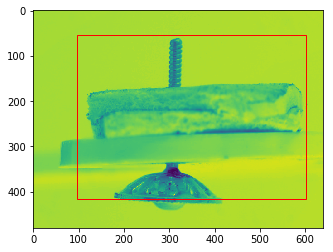

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#Verigying before submit
# Create figure and axes
imx = np.random.choice(os.listdir('test/'))
im = cv2.imread('test/' + imx)
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#im = np.expand_dims(gray, axis = -1)
fig,ax = plt.subplots(1)
x1 = submission.loc[submission['image_name'] == imx,'x1'].values[0]
x2 = submission.loc[submission['image_name'] == imx,'x2'].values[0]
y1 = submission.loc[submission['image_name'] == imx,'y1'].values[0]
y2 = submission.loc[submission['image_name'] == imx,'y2'].values[0]

# Display the image
#ax.imshow(im[0,:,:,0])
ax.imshow(im)

# Create a Rectangle patch
rect2 = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect2)

plt.show()

In [14]:
submission.to_csv('submit_inceptionval8922-9epochs.csv', index = False)